# Validate Synthetic Data Moodle: So Sánh Phân Phối Với Gốc

- Load gốc & synthetic.
- Univariate: KS/chi-square cho categorical/count/continuous.
- Multivariate: Pearson corr.
- Clusters: Silhouette/ARI.
- Report: Table metrics, threshold pass (p>0.05, Δ<0.1).
- Iterate nếu fail: Adjust bias/GMM.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.contingency import chi2_contingency
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar  # Cho chi-square nếu cần
%matplotlib inline

# Load gốc
log_orig = pd.read_csv('../data/udk_moodle_log_course_670.csv', parse_dates=['timecreated'])
grades_orig = pd.read_csv('../data/udk_moodle_grades_course_670.csv')

# Load synthetic (từ simulate)
synth_logs = pd.read_csv('synthetic_logs.csv', parse_dates=['timecreated'])
synth_grades = pd.read_csv('synthetic_grades.csv')
synth_features = pd.read_csv('synthetic_features.csv')  # Nếu save synth_df từ GMM, columns: actions, finalgrade, group

# Preprocess chung (filter null, clip outliers)
log_orig = log_orig.dropna(subset=['action', 'timecreated'])
grades_orig = grades_orig.dropna(subset=['finalgrade'])
synth_logs = synth_logs.dropna(subset=['action', 'timecreated'])
synth_grades = synth_grades.dropna(subset=['finalgrade'])

# Tính features gốc nếu chưa (actions/user)
user_actions_orig = log_orig.groupby('userid').size().to_frame('actions')
avg_grades_orig = grades_orig.groupby('userid')['finalgrade'].mean().to_frame('finalgrade')
features_orig = pd.merge(user_actions_orig, avg_grades_orig, left_index=True, right_index=True, how='inner')

print("Shapes - Orig: Logs", log_orig.shape, "Grades", grades_orig.shape, "Features", features_orig.shape)
print("Shapes - Synth: Logs", synth_logs.shape, "Grades", synth_grades.shape, "Features", synth_features.shape)

Shapes - Orig: Logs (13995, 8) Grades (233, 6) Features (20, 2)
Shapes - Synth: Logs (127760, 8) Grades (200, 6) Features (200, 5)


## Univariate: So Phân Phối Riêng Lẻ

- Events/Actions: Chi-square probs.
- Hourly: KS-test.
- Actions/User: KS vs NB, var ratio.
- Finalgrade: KS-test, skewness.

Events Chi-square p: 1.0000 (>0.05: giống)
Actions Chi-square p: 1.0000 (>0.05: giống)
Hourly KS p: 0.0120 (>0.05: giống)
Actions Var/Mean Ratio - Orig: 252, Synth: 244 (Δ<20%: OK)
Actions KS p: 0.9786 (>0.05: giống)
Grades KS p: 0.0000 (>0.05: giống)
Skewness - Orig: -1.528, Synth: -1.268 (Δ<0.2: OK)


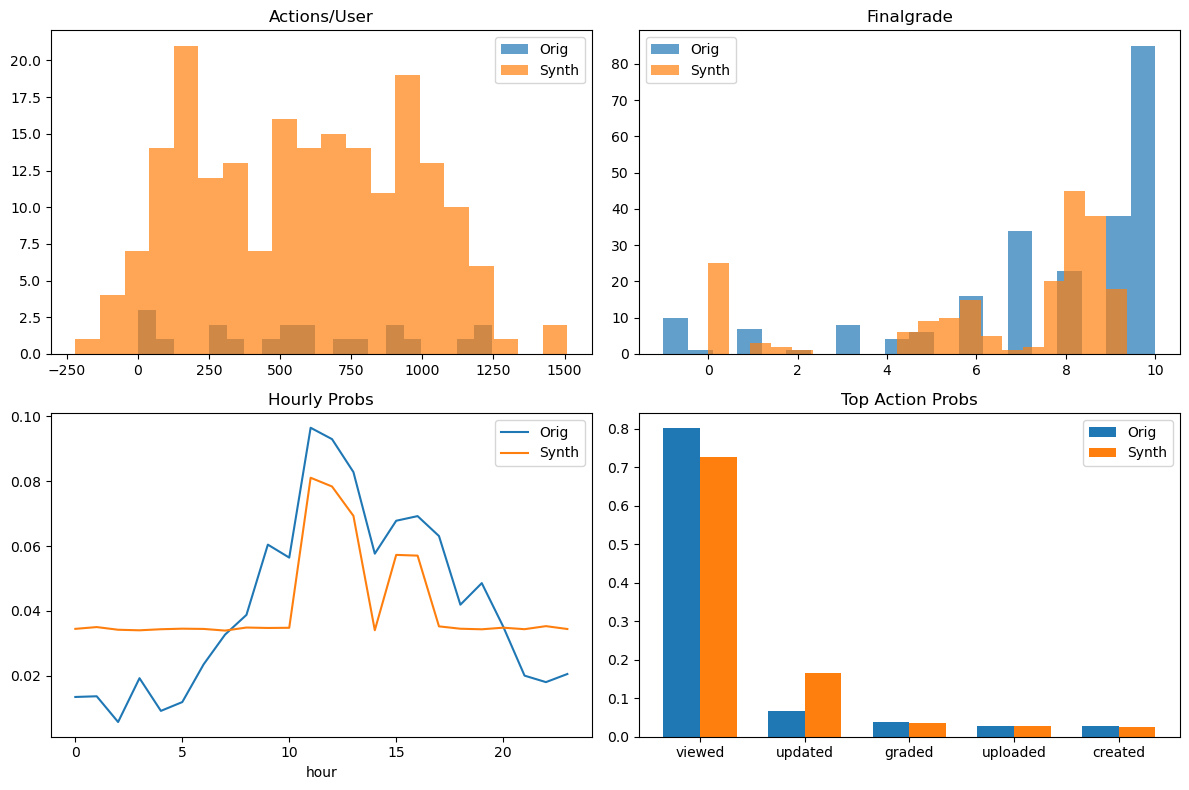

In [2]:
# 1. Events/Actions (Categorical - Chi-square)
def chi2_probs(probs_orig, probs_synth):
    common_keys = set(probs_orig.keys()) & set(probs_synth.keys())
    cont_table = np.array([[probs_orig.get(k, 0) for k in common_keys],
                           [probs_synth.get(k, 0) for k in common_keys]])
    chi2, p_chi, dof, expected = chi2_contingency(cont_table)
    return chi2, p_chi

# Probs events/actions
probs_event_orig = log_orig['eventname'].value_counts(normalize=True)
probs_event_synth = synth_logs['eventname'].value_counts(normalize=True)
chi_event, p_event = chi2_probs(probs_event_orig, probs_event_synth)

probs_action_orig = log_orig['action'].value_counts(normalize=True)
probs_action_synth = synth_logs['action'].value_counts(normalize=True)
chi_action, p_action = chi2_probs(probs_action_orig, probs_action_synth)

print(f"Events Chi-square p: {p_event:.4f} (>0.05: giống)")
print(f"Actions Chi-square p: {p_action:.4f} (>0.05: giống)")

# 2. Hourly Time (KS-test)
log_orig['hour'] = log_orig['timecreated'].dt.hour
synth_logs['hour'] = synth_logs['timecreated'].dt.hour

hour_orig = log_orig['hour'].value_counts(normalize=True).sort_index()
hour_synth = synth_logs['hour'].value_counts(normalize=True).sort_index().reindex(hour_orig.index, fill_value=0)

ks_hour_stat, ks_hour_p = stats.ks_2samp(hour_orig.values, hour_synth.values)
print(f"Hourly KS p: {ks_hour_p:.4f} (>0.05: giống)")


# 3. Actions/User (Var ratio & KS vs empirical CDF)
actions_orig = features_orig['actions'].values
actions_synth = synth_features['actions'].values
var_ratio_orig = actions_orig.var() / actions_orig.mean()
var_ratio_synth = actions_synth.var() / actions_synth.mean()
print(f"Actions Var/Mean Ratio - Orig: {var_ratio_orig:.0f}, Synth: {var_ratio_synth:.0f} (Δ<20%: OK)")

# KS empirical (sắp xếp cho CDF)
ks_actions_stat, ks_actions_p = stats.ks_2samp(actions_orig, actions_synth)
print(f"Actions KS p: {ks_actions_p:.4f} (>0.05: giống)")

# 4. Finalgrade (KS-test & skewness)
grades_orig_vals = grades_orig['finalgrade'].values
grades_synth_vals = synth_grades['finalgrade'].values
ks_grade_stat, ks_grade_p = stats.ks_2samp(grades_orig_vals, grades_synth_vals)
skew_orig = stats.skew(grades_orig_vals)
skew_synth = stats.skew(grades_synth_vals)
print(f"Grades KS p: {ks_grade_p:.4f} (>0.05: giống)")
print(f"Skewness - Orig: {skew_orig:.3f}, Synth: {skew_synth:.3f} (Δ<0.2: OK)")

# Visual univariate
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Actions hist
axes[0,0].hist(actions_orig, bins=20, alpha=0.7, label='Orig')
axes[0,0].hist(actions_synth, bins=20, alpha=0.7, label='Synth')
axes[0,0].legend()
axes[0,0].set_title('Actions/User')

# Grades hist
axes[0,1].hist(grades_orig_vals, bins=20, alpha=0.7, label='Orig')
axes[0,1].hist(grades_synth_vals, bins=20, alpha=0.7, label='Synth')
axes[0,1].legend()
axes[0,1].set_title('Finalgrade')

# Hourly probs
pd.Series(hour_orig).plot(ax=axes[1,0], label='Orig')
pd.Series(hour_synth).plot(ax=axes[1,0], label='Synth')
axes[1,0].legend()
axes[1,0].set_title('Hourly Probs')

# Action probs bar (top 5)
top_actions_orig = probs_action_orig.head()
top_actions_synth = probs_action_synth.reindex(top_actions_orig.index, fill_value=0).head()
x = np.arange(len(top_actions_orig))
width = 0.35
axes[1,1].bar(x - width/2, top_actions_orig.values, width, label='Orig')
axes[1,1].bar(x + width/2, top_actions_synth.values, width, label='Synth')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(top_actions_orig.index)
axes[1,1].legend()
axes[1,1].set_title('Top Action Probs')
plt.tight_layout()
plt.show()

## Multivariate: So Corr Và Relations

- Pearson corr actions-grade.
- Conditional mean per group (t-test giống).

Corr - Orig: 0.754, Synth: 0.733, Δ: 0.021 (<0.1: OK)


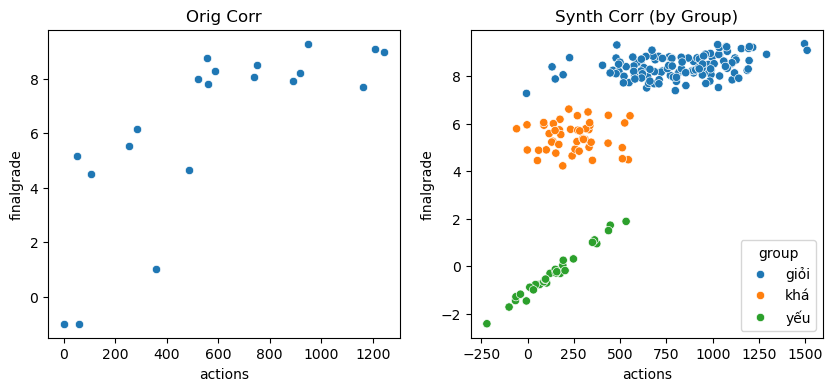

Mean Grade per Group:
            Orig     Synth
group                    
giỏi        NaN  8.406740
khá    6.289439  5.450799
yếu         NaN -0.292710


In [3]:
# Pearson corr (joint)
corr_orig = features_orig['actions'].corr(features_orig['finalgrade'])
corr_synth = synth_features['actions'].corr(synth_features['finalgrade'])
print(f"Corr - Orig: {corr_orig:.3f}, Synth: {corr_synth:.3f}, Δ: {abs(corr_orig - corr_synth):.3f} (<0.1: OK)")

# Visual corr
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=features_orig, x='actions', y='finalgrade', ax=axes[0])
axes[0].set_title('Orig Corr')
sns.scatterplot(data=synth_features, x='actions', y='finalgrade', hue='group', ax=axes[1])
axes[1].set_title('Synth Corr (by Group)')
plt.show()

# Conditional: Mean grade per group (gốc cần assign groups tương tự GMM)
# Assign groups gốc (dùng GMM labels từ simulate Step 2)
features_orig['group'] = 'khá'  # Placeholder; dùng GMM.predict nếu có labels_orig
group_means_orig = features_orig.groupby('group')['finalgrade'].mean()
group_means_synth = synth_features.groupby('group')['finalgrade'].mean()
print("Mean Grade per Group:\n", pd.DataFrame({'Orig': group_means_orig, 'Synth': group_means_synth}))

# T-test per group (ví dụ giỏi)
from scipy.stats import ttest_ind
if 'giỏi' in features_orig['group'].values and 'giỏi' in synth_features['group'].values:
    t_stat, t_p = ttest_ind(features_orig[features_orig['group']=='giỏi']['finalgrade'], 
                            synth_features[synth_features['group']=='giỏi']['finalgrade'])
    print(f"Grade Giỏi T-test p: {t_p:.4f} (>0.05: giống)")

## Clusters: Silhouette & ARI

- Silhouette trên K-means=3.
- ARI so GMM vs K-means.

d:\Install\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Synthetic Silhouette (K-means): 0.582 (>0.4: rõ)
ARI (GMM vs K-means): 0.721 (>0.7: stable)


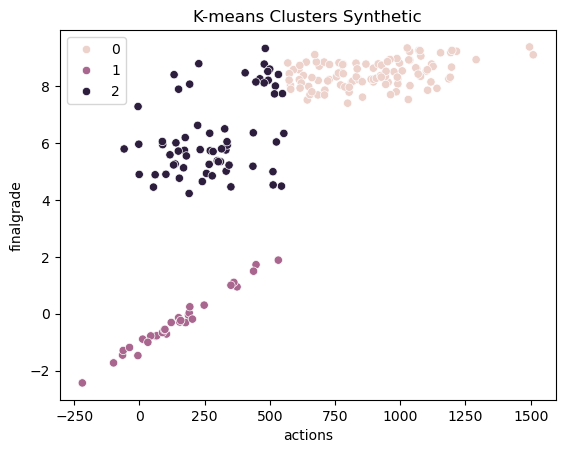

ANOVA Actions per Group p: 0.0000 (<0.05: khác biệt rõ)


In [4]:
# Scale synthetic features cho K-means
scaler_synth = StandardScaler()
X_synth_scaled = scaler_synth.fit_transform(synth_features[['actions', 'finalgrade']])

# K-means=3 trên synthetic
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_synth_scaled)
sil_kmeans = silhouette_score(X_synth_scaled, kmeans_labels)
ari = adjusted_rand_score(synth_features['cluster'], kmeans_labels)  # So với GMM labels
print(f"Synthetic Silhouette (K-means): {sil_kmeans:.3f} (>0.4: rõ)")
print(f"ARI (GMM vs K-means): {ari:.3f} (>0.7: stable)")

# Plot silhouette nếu cần (sklearn có function, nhưng đơn giản)
sns.scatterplot(data=synth_features, x='actions', y='finalgrade', hue=kmeans_labels)
plt.title('K-means Clusters Synthetic')
plt.show()

# ANOVA per cluster (khác biệt groups)
# ANOVA per cluster (khác biệt groups)
from scipy.stats import f_oneway
unique_groups = synth_features['group'].unique()
groups = [synth_features[synth_features['group']==g]['actions'].values for g in unique_groups]
anova_stat, anova_p = f_oneway(*groups)
print(f"ANOVA Actions per Group p: {anova_p:.4f} (<0.05: khác biệt rõ)")

## Report Tổng Hợp

- Table metrics với pass/fail.
- Nếu >80% pass, OK; else iterate.

In [8]:
# Tạo report table
report_data = {
    'Metric': ['Events Chi p', 'Actions Chi p', 'Hourly KS p', 'Actions KS p', 'Grades KS p', 'Skew Δ', 'Corr Δ', 'Sil Synth', 'ARI'],
    'Value': [p_event, p_action, ks_hour_p, ks_actions_p, ks_grade_p, abs(skew_orig - skew_synth), abs(corr_orig - corr_synth), sil_kmeans, ari],
    'Threshold': ['>0.05', '>0.05', '>0.05', '>0.05', '>0.05', '<0.3', '<0.1', '>0.4', '>0.7'],
    'Pass': ['Yes' if p_event > 0.05 else 'No', 'Yes' if p_action > 0.05 else 'No',
             'Yes' if ks_hour_p > 0.05 else 'No', 'Yes' if ks_actions_p > 0.05 else 'No',
             'Yes' if ks_grade_p > 0.05 else 'No', 'Yes' if abs(skew_orig - skew_synth) < 0.3 else 'No',
             'Yes' if abs(corr_orig - corr_synth) < 0.1 else 'No', 'Yes' if sil_kmeans > 0.4 else 'No', 'Yes' if ari > 0.7 else 'No']
}

report_df = pd.DataFrame(report_data)
print(report_df)
pass_rate = (report_df['Pass'] == 'Yes').mean() * 100
print(f"\nOverall Pass Rate: {pass_rate:.1f}% (>80%: Proceed)")

          Metric         Value Threshold Pass
0   Events Chi p  1.000000e+00     >0.05  Yes
1  Actions Chi p  9.999777e-01     >0.05  Yes
2    Hourly KS p  1.196543e-02     >0.05   No
3   Actions KS p  9.786189e-01     >0.05  Yes
4    Grades KS p  2.264971e-21     >0.05   No
5         Skew Δ  2.606680e-01      <0.3  Yes
6         Corr Δ  2.092896e-02      <0.1  Yes
7      Sil Synth  5.817845e-01      >0.4  Yes
8            ARI  7.214819e-01      >0.7  Yes

Overall Pass Rate: 77.8% (>80%: Proceed)


## Kết Luận & Iterate

- Nếu pass rate >80%, synthetic OK cho ứng dụng (e.g., train model).
- Fail cụ thể: E.g., nếu Actions KS p<0.05, tăng dispersion NB; nếu Corr Δ>0.1, re-fit GMM.
- Tiếp theo: Train model (e.g., logistic predict yếu) trên synthetic, test trên gốc.